<a href="https://colab.research.google.com/github/7201krap/PYTORCH_introduction_to_pytorch/blob/main/FINAL/selectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [26]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = datasets.MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, 
                                               batch_size=50, 
                                               shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


In [27]:
# Define the model 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid  = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        pred = self.linear_2(x)

        return pred

model = Model()

In [28]:
def get_activation():    
    def hook(module, input, output):
        model.layer_activations = output
    return hook
    
model.sigmoid.register_forward_hook(get_activation())

In [29]:
# adagrad 
optimizer  = torch.optim.Adagrad(model.parameters(), lr=0.1)

In [30]:
hidden_layer_each_neuron = [{0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]} for x in range(256)]
hidden_layer_each_neuron = np.array(hidden_layer_each_neuron)

In [31]:
len(hidden_layer_each_neuron)

256

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
no_epochs = 20
train_loss = list()
test_loss  = list()
test_acc   = list()

best_test_loss = 1

for epoch in range(no_epochs):
    total_train_loss = 0
    total_test_loss = 0

    # training
    # set up training mode 
    model.train()

    for itr, (images, label) in enumerate(train_dataloader):

        optimizer.zero_grad()

        pred = model(images)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Print/Append activation of the hidden layer 
        # print(model.layer_activations.shape)
        # model.layer_activations

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # testing 
    # change to evaluation mode 
    model.eval()
    total = 0
    for itr, (images, labels) in enumerate(test_dataloader):

        pred = model(images)

        loss = criterion(pred, labels)
        total_test_loss += loss.item()

        # we now need softmax because we are testing.
        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if labels[i] == torch.max(p.data, 0)[1]:
                total = total + 1

        # print("1:", labels.shape)   # 50 
        # print("2:", model.layer_activations.shape)  # 50, 256 

        # print(labels[0].shape) # 1
        # print(model.layer_activations[0].shape) # 256 

        # find selectivity at the final epoch 
        if epoch == no_epochs - 1: # last epoch 
            for activation, label in zip(model.layer_activations, labels):
                # shape of activation and label: 256 and 1 
                
                # get the actual value of item. This is because label is now Tensor 
                label = label.item()

                # this is not part of gradient calculcation 
                with torch.no_grad():
                    activation = activation.numpy()

                # for each image/label, append activation value of neuron 
                for i in range(256):    # number of neurons in hidden layer 
                    hidden_layer_each_neuron[i][label].append(activation[i])


    # caculate accuracy 
    accuracy = total / len(mnist_testset)

    # append accuracy here
    test_acc.append(accuracy)

    # append test loss here 
    total_test_loss = total_test_loss / (itr + 1)
    test_loss.append(total_test_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Test Loss: {:.8f}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_test_loss, accuracy))

    if total_test_loss < best_test_loss:
        best_test_loss = total_test_loss
        print("Saving the model state dictionary for Epoch: {} with Test loss: {:.8f}".format(epoch + 1, total_test_loss))
        torch.save(model.state_dict(), "model.dth")


In [66]:
#   there are 256 neurons. 
print(np.array(hidden_layer_each_neuron).shape)

(256,)


In [69]:
print(len(hidden_layer_each_neuron[0]))
print(len(hidden_layer_each_neuron[1]))
#   .
#   .
#   .
#   For each neuron in hidden layer, there are 10 classes: 0 to 9 
print(len(hidden_layer_each_neuron[255]))

10
10
10


In [86]:
# hidden_layer_each_neuron[9][5]: 9th neuron's activation values of number(class) 5
print(hidden_layer_each_neuron[9][5])

[2.2152939e-08, 1.2682847e-07, 5.483753e-05, 8.197479e-11, 4.8451526e-10, 1.02101765e-07, 4.570579e-06, 4.6502002e-09, 0.0012101907, 9.5782276e-08, 4.5645145e-08, 0.00012607494, 0.00010906463, 3.5659745e-10, 7.995135e-10, 2.2921167e-06, 5.0661164e-10, 1.4037599e-13, 1.0361957e-09, 8.729914e-05, 3.1058284e-10, 1.2796804e-08, 4.4087867e-07, 1.231415e-08, 1.6656802e-10, 4.473811e-13, 2.9450549e-08, 4.3935273e-05, 6.7375174e-07, 1.5456625e-09, 1.5998901e-05, 0.00020677291, 1.1211622e-09, 6.189113e-08, 1.1279942e-05, 3.7402785e-12, 5.5450564e-06, 1.37073575e-05, 1.0362978e-05, 3.571778e-05, 0.0035881018, 1.3439749e-11, 1.2396073e-06, 0.0015158658, 7.1811914e-06, 1.6166011e-11, 7.731617e-07, 0.00065727864, 3.7735674e-05, 8.954558e-09, 0.007084122, 2.4887786e-05, 2.397147e-05, 7.665211e-07, 2.6869605e-08, 1.7444115e-08, 4.685196e-06, 8.457191e-08, 2.1783889e-11, 1.7630226e-08, 1.3316596e-06, 0.0067777615, 4.5459055e-06, 3.7687056e-07, 3.044371e-06, 4.390295e-08, 4.2994936e-09, 0.0011664312, 5

In [70]:
# I will now try to find the average of each class for each neuron.
# check out the next cell 
avg_activations = [dict() for x in range(256)]
for i, neuron in enumerate(hidden_layer_each_neuron):
    for k, v in neuron.items():
        # v is the list of activations for hidden layer's neuron k 
        avg_activations[i][k] = sum(v) / float(len(v))

In [91]:
print(np.average(hidden_layer_each_neuron[0][0]))
print(np.average(hidden_layer_each_neuron[1][0]))
print(np.average(hidden_layer_each_neuron[255][0]))

0.010649697
0.00022597237
0.005219437


In [74]:
print(avg_activations[0])
print(avg_activations[1])
#   .
#   .
#   .
print(avg_activations[255])

{0: 0.01064969590983842, 1: 0.011579395830608545, 2: 0.018659652275849134, 3: 0.0036669818881303676, 4: 0.022191845663284367, 5: 0.0017384049338187756, 6: 0.14585993083808313, 7: 0.009409720661021154, 8: 0.0015985387607409323, 9: 0.005948913598712139}
{0: 0.00022597237761217174, 1: 0.6096585417206772, 2: 0.0242293587585628, 3: 0.0013401000239541441, 4: 0.002006061503732474, 5: 0.00187453448276193, 6: 0.0054396448049770525, 7: 0.0036435045470692, 8: 0.0008762409977984163, 9: 0.00018247453366984832}
{0: 0.005219437003079519, 1: 0.013480590857224396, 2: 0.056289916380797236, 3: 0.0007867360751251437, 4: 0.0009318888842806899, 5: 0.001162618218784777, 6: 0.028084359181861602, 7: 0.0015552248389612052, 8: 0.0011603632335744068, 9: 0.00018172075018022267}


In [92]:
# generate 256 lists to get only values in avg_activations
only_activation_vals = [list() for x in range(256)]

# selectivity_list contains all of the selectivity of each neuron 
selectivity_list = list()

# get only values from avg_activations
for i, avg_activation in enumerate(avg_activations):
    for value in avg_activation.values():
        only_activation_vals[i].append(value)

# compare the result of avg_activations and only_activation_vals.
# The values of the dictionary should be same 
print("1", avg_activations[0])
print("2", only_activation_vals[0])
print()


for activation_val in only_activation_vals:
    # find u_max 
    u_max = np.max(activation_val)

    # find u_minus_max 
    u_minus_max = (np.sum(activation_val) - u_max) / 9

    # find selectivity 
    selectivity = (u_max - u_minus_max) / (u_max + u_minus_max)

    # append selectivity value to selectivity_list
    selectivity_list.append(selectivity)

# length of selectivity_list should be 256 because there are 256 neurons in the hidden layer 
print("\nlength of selectivity_list:", len(selectivity_list))
print("average selectivity of all neurons:", np.average(selectivity_list))

1 {0: 0.01064969590983842, 1: 0.011579395830608545, 2: 0.018659652275849134, 3: 0.0036669818881303676, 4: 0.022191845663284367, 5: 0.0017384049338187756, 6: 0.14585993083808313, 7: 0.009409720661021154, 8: 0.0015985387607409323, 9: 0.005948913598712139}
2 [0.01064969590983842, 0.011579395830608545, 0.018659652275849134, 0.0036669818881303676, 0.022191845663284367, 0.0017384049338187756, 0.14585993083808313, 0.009409720661021154, 0.0015985387607409323, 0.005948913598712139]


length of selectivity_list: 256
average selectivity of all neurons: 0.6987336005218048


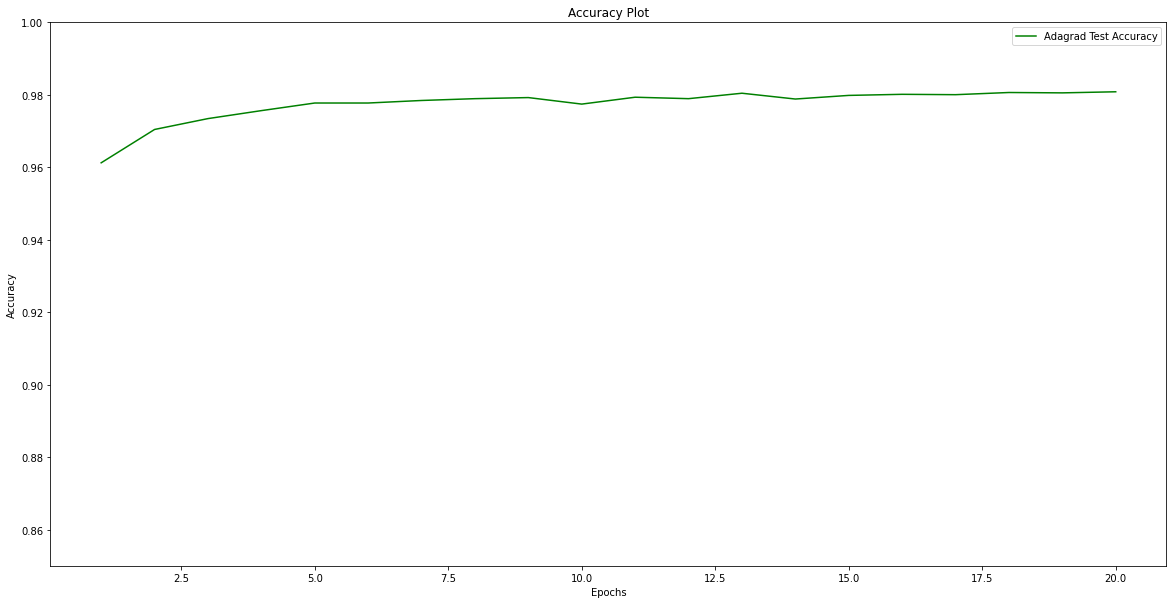

In [79]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), test_acc, label="Adagrad Test Accuracy", color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1)
plt.title("Accuracy Plot")
plt.legend(loc='best')
plt.show()